# Final Phase 2 Project 

**Group Number:** 5

**Group Members:**
- Elizabeth Gichure  
- Victor Wasuna  
- June Masolo  
- Hellen Khisa

**Student pace:** Part-time

**Scheduled project review date/time:**

**Instructor name:** Christine Kirimi

# Step 1: Business Understanding  

**Big Films Business Limited** is planning to launch a new movie studio. Given that this is a new business venture and that the company doesn't know much about creating movies, the mandate therefore is to carry out a research on what types of films are doing the best at the box office and translate the findings into actionable insights to help the management of the company make data driven decisions on the best kind of films to produce.

The research will be done based on the following historical data set:
   
1. **Box Office Mojo**
2. **IMDB**
3. **Rotten Tomatoes**
4. **TheMovieDB**
5. **The Numbers**

---
## Business/ Project Goal:
To provide **Big Films Business Limited** with a data-backed strategy for its initial film slate, minimizing financial risk while building a foundation for critical and commercial success.

---

##  Project Objectives  

1. **Identify the best movie genres to produce**  
2. **Understand the average runtime per genre** that Big Films Business Limited can reference when producing films
3. **Highlight top film directors and writers** that Big Films Business Limited can learn from or potentially hire
4. **Identify movie genres that have the highest revenue with low production cost**

---

### Approach taken to address the above objectives  

### Objective 1: Best Genres  
- Identified genres with the **highest average rating**  
- Identified genres with the **highest number of votes**
  
### Objective 2: Average Movies Runtime
- Calculate the mean timerun per genre

### Objective 3: Best Directors & Writers  
- Identified **directors** who produced films with the highest average ratings  
- Identified **writers** who produced films with the highest average ratings

### Objective 4: Highest revenue genres with low production costs

- Identify using the genre with highest revenue generation (Worldwide Gross column) and low production cost (Production_Budget Columns)


# Step 2: Data Preparation
### Importing modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

### The following datasets have been used for this analysis:
- im.db


**Analysing im.db**

In [3]:
import zipfile, sqlite3, pandas as pd

# Correct full path
zip_path = r"C:\Users\Hp\Documents\MORINGA\trial-project\dsc-phase-2-project-v3\zippedData\im.db.zip"
extract_path = r"C:\Users\Hp\Documents\MORINGA\trial-project\dsc-phase-2-project-v3\zippedData"

# Unzip
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Connect to extracted .db file
db_path = extract_path + r"\im.db"
conn = sqlite3.connect(db_path)


### Selected Tables and columns for analysis  

#### i) **Movie_basics**  
- `genres`  
- `runtime_minutes`  
- `movie_id`  

#### ii) **Movie_rating**  
- `averagerating`  
- `numvotes`  
- `movie_id`  

#### iii) **Directors**  
- `person_id`  
- `movie_id`  

#### iv) **Writers**  
- `person_id`  
- `movie_id`  

#### v) **Persons**  
- `primary_name`  
- `birth_date`  
- `death_date`  


### We Merged both the movie_ratings table and movie_basics table 

In [4]:
query3 = """
SELECT 
    r.movie_id,
    r.averagerating,
    r.numvotes,
    b.primary_title,
    b.runtime_minutes,
    b.genres
FROM movie_ratings r
JOIN movie_basics b
    ON r.movie_id = b.movie_id;
"""
ratings_basics_df = pd.read_sql(query3, conn)
ratings_basics_df.head(4)

,movie_id,averagerating,numvotes,primary_title,runtime_minutes,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,117.0,Romance
1,tt10384606,8.9,559,Borderless,87.0,Documentary
2,tt1042974,6.4,20,Just Inès,90.0,Drama
3,tt1043726,4.2,50352,The Legend of Hercules,99.0,"Action,Adventure,Fantasy"


### Handling Missing Values - ratings_basics_df  

To address missing values, we first noticed that the **genres column contains many categories**.  
Instead of filling missing runtimes with a single global value, we **grouped the data by genre**,  
calculated the **median runtime for each genre**, and then used those medians to fill the missing values **genre by genre**.    

-  Using this method, we successfully filled **6,797 missing runtimes**.  

After that step, only a small fraction of missing values remained (around **1% of the dataset**).  
Given how minimal this is, we decided to **drop these rows**:  

- `runtime_minutes` → **823 rows** (≈ 1.11%)  
- `genres` → **804 rows** (≈ 1.09%)  


In [5]:
# percentage missing values for ratings_basics_df columns

# Count of missing values
missing_count = ratings_basics_df.isna().sum()

total_rows = len(ratings_basics_df)

# Percentage of missing values
missing_percent = (missing_count / total_rows) * 100

# Combine into one DataFrame
missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percent": missing_percent.round(2)  # round to 2 decimal places
})

missing_df

,missing_count,missing_percent
movie_id,0,0.00
averagerating,0,0.00
numvotes,0,0.00
primary_title,0,0.00
runtime_minutes,7620,10.32
genres,804,1.09


In [6]:
# Fill missing runtimes with the median runtime for each genre
ratings_basics_df["runtime_minutes"] = ratings_basics_df.groupby("genres")["runtime_minutes"].transform(
    lambda x: x.fillna(x.mean())
)

# Drop rows where either runtime_minutes or genres is missing
ratings_basics_df = ratings_basics_df.dropna(subset=["runtime_minutes", "genres"])
ratings_basics_df.isna().sum()



movie_id           0
averagerating      0
numvotes           0
primary_title      0
runtime_minutes    0
genres             0
dtype: int64

### Objective 1: Best Genres
- We grouped the dataset by genre and averagerating, sorted the results by average rating in descending order, and then selected the top 15 genres with the highest ratings for visualization.  

In [7]:
# Group by both genres and average rating
genre_avg = (
    ratings_basics_df
    .groupby("genres")["averagerating"]
    .mean()
    .round(1)
    .reset_index()
    .sort_values(by="averagerating", ascending=False)
)

top_15_genre_ratings = genre_avg.head(15)
top_15_genre_ratings.head()


,genres,averagerating
442,"Comedy,Documentary,Fantasy",9.4
622,"Documentary,Family,Musical",9.3
824,Game-Show,9.0
763,"Drama,Short",8.8
670,"Documentary,News,Sport",8.8


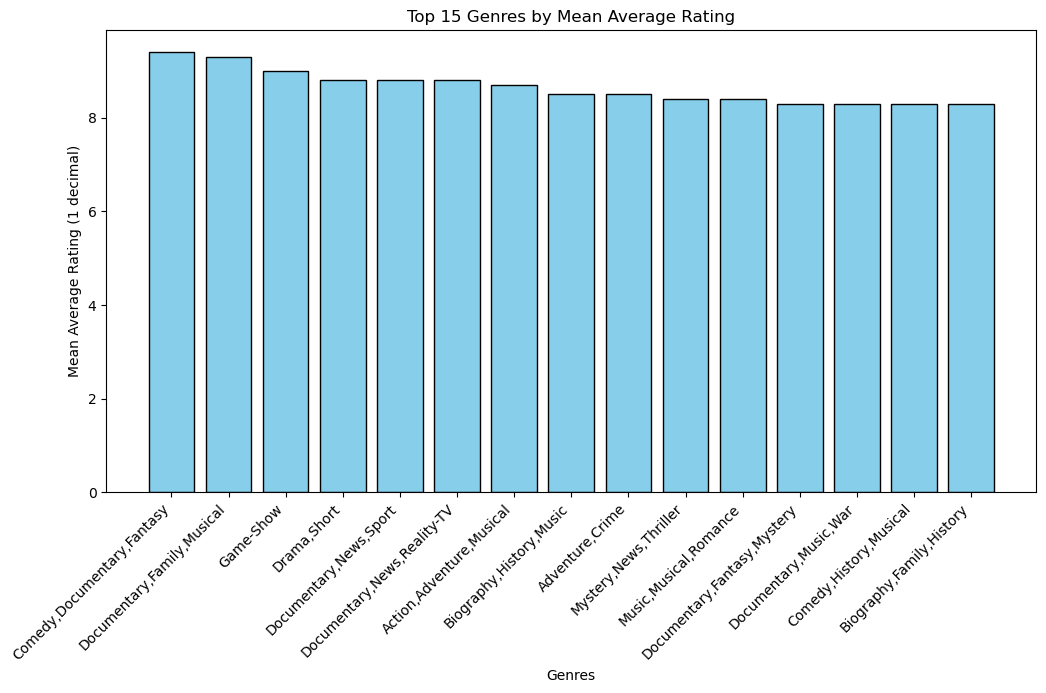

In [12]:
import os

# ✅ Create 'images' folder if it doesn't exist
os.makedirs("images", exist_ok=True)

plt.figure(figsize=(12,6))
plt.bar(top_15_genre_ratings["genres"], 
        top_15_genre_ratings["averagerating"], 
        color="skyblue", edgecolor="black")

plt.title("Top 15 Genres by Mean Average Rating")
plt.xlabel("Genres")
plt.ylabel("Mean Average Rating (1 decimal)")
plt.xticks(rotation=45, ha="right")

# ✅ Save plot as PNG inside 'images' folder
plt.savefig("images/top_genres.png", dpi=300, bbox_inches="tight")

plt.show()


- We grouped the dataset by genre and numvotes, sorted the results in descending order based on the number of votes, and then selected the top 15 genres for visualization. 

In [10]:
# Group by both genres and average rating
genre_avg2 = (
    ratings_basics_df
    .groupby("genres")["numvotes"]
    .sum()
    .round(1)
    .reset_index()
    .sort_values(by="numvotes", ascending=False)
)

top_15_genre_votes = genre_avg2.head(15)
top_15_genre_votes.head()

,genres,numvotes
17,"Action,Adventure,Sci-Fi",23023248
10,"Action,Adventure,Fantasy",9658883
153,"Adventure,Animation,Comedy",8687435
682,Drama,8395521
463,"Comedy,Drama,Romance",7665463


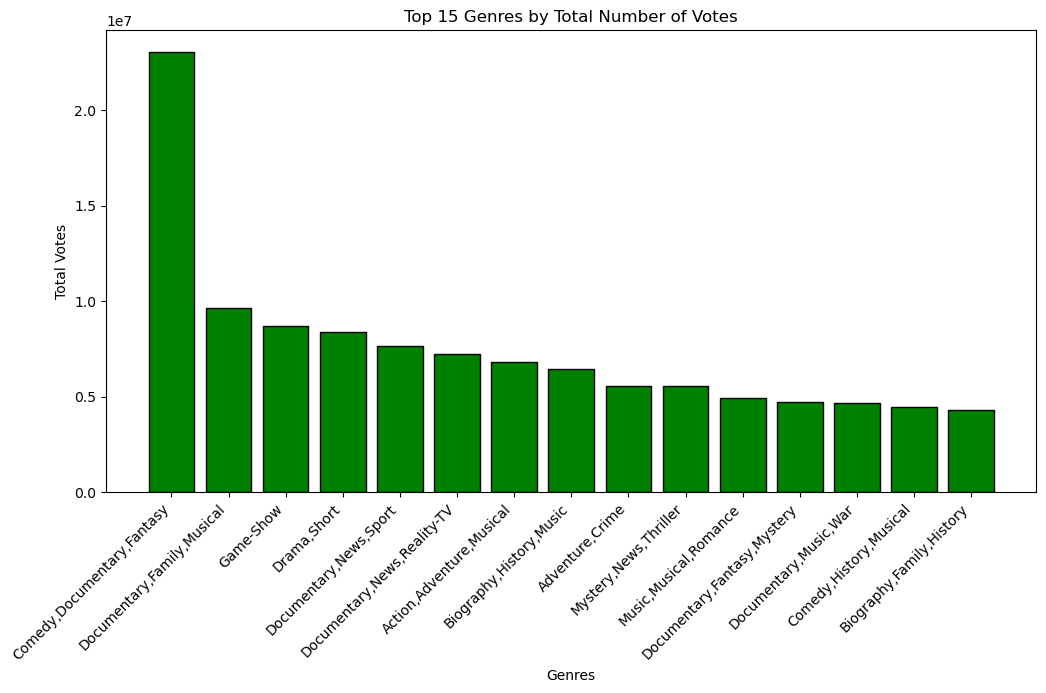

In [13]:
import os

# ✅ Make sure the 'images' folder exists
os.makedirs("images", exist_ok=True)

plt.figure(figsize=(12,6))
plt.bar(top_15_genre_ratings["genres"], 
        top_15_genre_votes["numvotes"], 
        color="green", edgecolor="black")

plt.title("Top 15 Genres by Total Number of Votes")
plt.xlabel("Genres")
plt.ylabel("Total Votes")
plt.xticks(rotation=45, ha="right")

# ✅ Save the plot as PNG
plt.savefig("images/top_genres_votes.png", dpi=300, bbox_inches="tight")

plt.show()


### Objective 3: Average Movies Runtime

- We split the `genres` column into a list of genres for each movie and then used `explode` to create separate rows for each genre. This allows us to analyze runtime and other metrics by individual genre.


### 

In [14]:
ratings_basics_df['genres'] = ratings_basics_df['genres'].str.split(',')
runtime_df = ratings_basics_df.explode('genres')
runtime_df.head(10)

,movie_id,averagerating,numvotes,primary_title,runtime_minutes,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,117.0,Romance
1,tt10384606,8.9,559,Borderless,87.0,Documentary
2,tt1042974,6.4,20,Just Inès,90.0,Drama
3,tt1043726,4.2,50352,The Legend of Hercules,99.0,Action
3,tt1043726,4.2,50352,The Legend of Hercules,99.0,Adventure
3,tt1043726,4.2,50352,The Legend of Hercules,99.0,Fantasy
4,tt1060240,6.5,21,Até Onde?,73.0,Mystery
4,tt1060240,6.5,21,Até Onde?,73.0,Thriller
5,tt1069246,6.2,326,Habana Eva,106.0,Comedy
5,tt1069246,6.2,326,Habana Eva,106.0,Romance


- Calculate the Mean runtime per genre

In [15]:
agg_runtime_df = (
    runtime_df[["genres", "runtime_minutes"]]
    .groupby("genres")
    .agg(average_runtime=('runtime_minutes', 'mean'))  # Named aggregation
    .reset_index()  # Reset index after aggregation
)

# Round the average runtime to whole numbers
agg_runtime_df['average_runtime'] = agg_runtime_df['average_runtime'].round().astype(int)

# Display the resulting DataFrame
agg_runtime_df.head()
agg_runtime_df = agg_runtime_df.sort_values(by = "genres",ascending = True)
agg_runtime_df

,genres,average_runtime
0,Action,104
1,Adult,87
2,Adventure,94
3,Animation,85
4,Biography,91
5,Comedy,97
6,Crime,99
7,Documentary,86
8,Drama,98
9,Family,92


- Ploting the genre verse average runtime

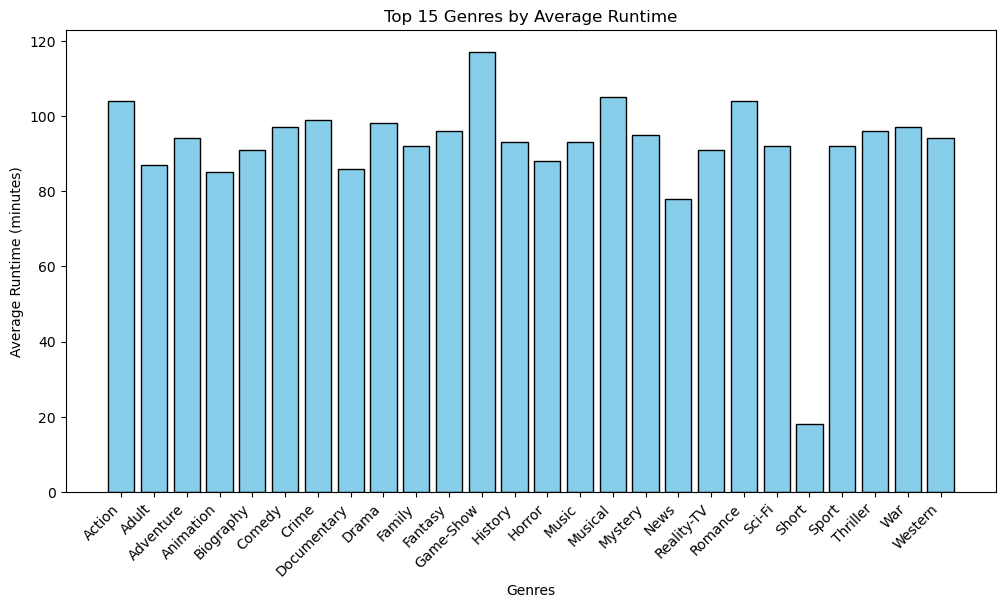

In [17]:
import os

# ✅ Make sure 'images' folder exists
os.makedirs("images", exist_ok=True)

# Plot bar chart
plt.figure(figsize=(12,6))
plt.bar(agg_runtime_df['genres'], 
        agg_runtime_df['average_runtime'], 
        color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Genres')
plt.ylabel('Average Runtime (minutes)')
plt.title('Top 15 Genres by Average Runtime')
plt.xticks(rotation=45, ha='right')  # Rotate genre labels for readability

# ✅ Save the plot
plt.savefig("images/avg_runtime.png", dpi=300, bbox_inches="tight")

plt.show()


### Objective 3: Best Directors & Writers

### Checking the best film directors
- We retrieved the directors data and selected the top 30 movies by average rating. Then, we grouped the data by `person_id` and `primary_name` and calculated the most frequent (`mode`) average rating for each director. This gives a representative rating per director.


In [18]:
query3 = """
SELECT d.person_id, d.movie_id, p.primary_name, r.averagerating
FROM directors AS d
JOIN persons AS p
    ON p.person_id = d.person_id
JOIN movie_ratings AS r
    ON d.movie_id = r.movie_id;
"""

directors_df = pd.read_sql(query3, conn)
top_directors_df = directors_df.sort_values(by = "averagerating", ascending = False).head(30)
# Group by person_id and primary_name, then get the mode of averagerating
mode_df = (
    top_directors_df
    .groupby(["person_id", "primary_name"])["averagerating"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

mode_df.sort_values(by = "averagerating", ascending = False).head(15)




,person_id,primary_name,averagerating
2,nm0880350,Mohamed Ulad-Mohand,10.0
7,nm2751775,Cristina Duarte,10.0
6,nm1249950,Robert Tutak,10.0
5,nm10616933,Ivana Diniz,10.0
11,nm3388005,Stephen Peek,10.0
22,nm6893562,Chad Carpenter,10.0
19,nm5472684,Michael J. Sanderson,10.0
16,nm4637768,Masahiro Hayakawa,10.0
15,nm4568586,Taylor Morden,10.0
14,nm4166962,Daniel Alexander,10.0


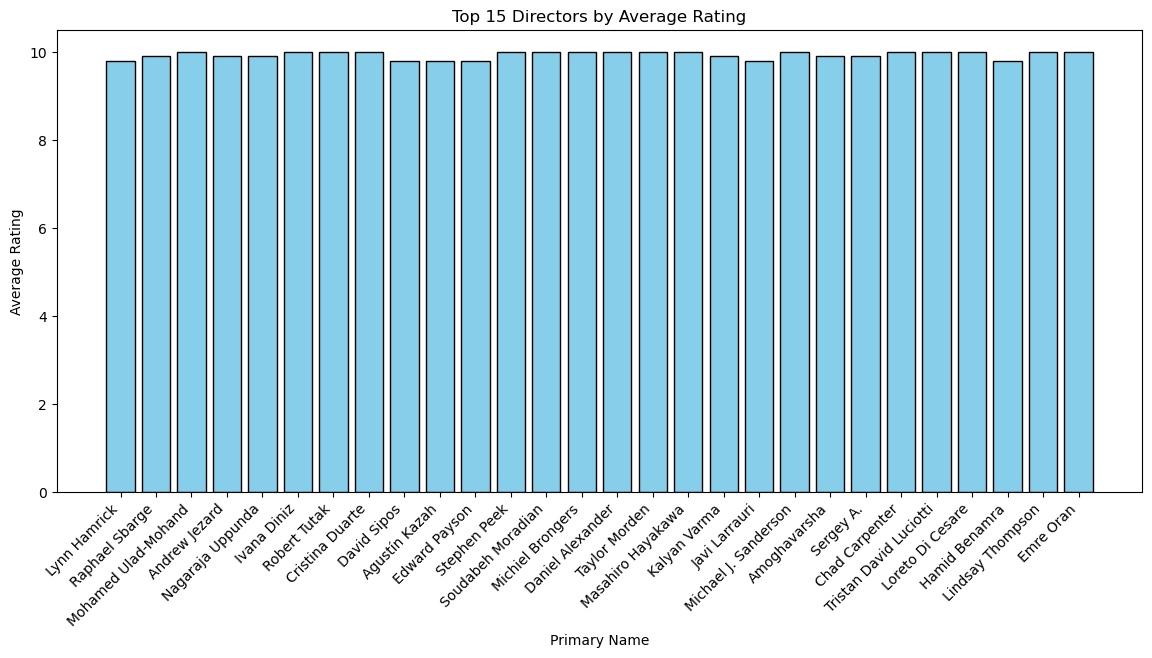

In [19]:
import os

# ✅ Make sure 'images' folder exists
os.makedirs("images", exist_ok=True)

# Plot vertical bar chart
plt.figure(figsize=(14,6))
plt.bar(mode_df["primary_name"], 
        mode_df["averagerating"], 
        color="skyblue", edgecolor="black")

plt.xlabel("Primary Name")
plt.ylabel("Average Rating")
plt.title("Top 15 Directors by Average Rating")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.ylim(0, 10.5)  # Slightly above 10 for better visualization

# ✅ Save the plot
plt.savefig("images/top_directors.png", dpi=300, bbox_inches="tight")

plt.show()


### Checking the best film writers
- We first read the writers data from the database into a DataFrame called writers_df. Then, we sort the data by averagerating in descending order and select the top 30 rows to focus on the highest-rated writers.

- Next, we group the top writers by person_id and primary_name. Within each group, we calculate the mode of averagerating, which gives the most frequently occurring rating for each writer. This ensures that if a writer has multiple entries, we summarize it with their most common rating.

In [20]:
query3 = """
SELECT w.person_id, w.movie_id, p.primary_name, r.averagerating
FROM writers AS w
JOIN persons AS p
    ON p.person_id = w.person_id
JOIN movie_ratings AS r
    ON w.movie_id = r.movie_id
;
"""

writers_df = pd.read_sql(query3, conn)
top_writers_df = writers_df.sort_values(by = "averagerating", ascending = False).head(30)
# Group by person_id and primary_name, then get the mode of averagerating
best_writers = (
    top_writers_df
    .groupby(["person_id", "primary_name"])["averagerating"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)


best_writers = best_writers.sort_values(by = "averagerating", ascending = False).head(15)


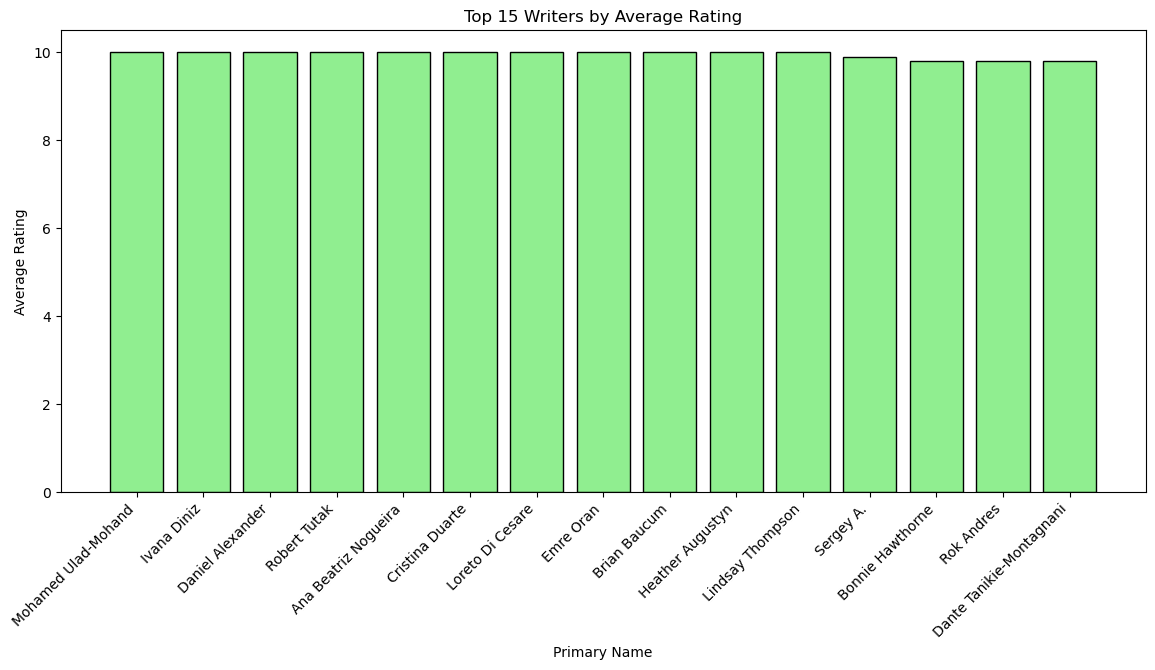

In [21]:
import os

# ✅ Make sure 'images' folder exists
os.makedirs("images", exist_ok=True)

# Plot vertical bar chart
plt.figure(figsize=(14,6))
plt.bar(best_writers["primary_name"], 
        best_writers["averagerating"], 
        color="lightgreen", edgecolor="black")

plt.xlabel("Primary Name")
plt.ylabel("Average Rating")
plt.title("Top 15 Writers by Average Rating")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.ylim(0, 10.5)  # Slightly above 10 for better visualization

# ✅ Save the plot
plt.savefig("images/top_writers.png", dpi=300, bbox_inches="tight")

plt.show()


### Objective 4: Movie genres that have the highest revenue with low production cost

In [23]:
# Path to your file
file_path = r"C:\Users\Hp\Documents\MORINGA\trial-project\dsc-phase-2-project-v3\zippedData/bom.movie_gross.csv.gz"

# Read the compressed CSV
movie_gross = pd.read_csv(file_path, compression='gzip')
movie_gross.sort_values(by = "domestic_gross", ascending = False).head(5)

,title,studio,domestic_gross,foreign_gross,year
1872,Star Wars: The Force Awakens,BV,936700000.0,"1,131.6",2015
3080,Black Panther,BV,700100000.0,646900000,2018
3079,Avengers: Infinity War,BV,678800000.0,"1,369.5",2018
1873,Jurassic World,Uni.,652300000.0,"1,019.4",2015
727,Marvel's The Avengers,BV,623400000.0,895500000,2012


In [24]:
ratings_basics_df.head(5)

,movie_id,averagerating,numvotes,primary_title,runtime_minutes,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,117.0,[Romance]
1,tt10384606,8.9,559,Borderless,87.0,[Documentary]
2,tt1042974,6.4,20,Just Inès,90.0,[Drama]
3,tt1043726,4.2,50352,The Legend of Hercules,99.0,"[Action, Adventure, Fantasy]"
4,tt1060240,6.5,21,Até Onde?,73.0,"[Mystery, Thriller]"


In [25]:
file_path = r"C:\Users\Hp\Documents\MORINGA\trial-project\dsc-phase-2-project-v3\zippedData/tn.movie_budgets.csv.gz"

# Read the compressed CSV
movie_budgets = pd.read_csv(file_path, compression='gzip')
movie_budgets.head()


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Cleaning the Production_budget, domestic_gross and worldwide_gross columns
- Removed the $ from the 3 columns

In [26]:
# Remove $ and , then convert to numeric
for col in ["production_budget", "domestic_gross", "worldwide_gross"]:
    movie_budgets[col] = movie_budgets[col].replace(r'[\$,]', '', regex=True).astype(int)

# Check result
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


- Identify the number of missing values. From the output, there are no missing values

movie_budgets.isna().sum()

- Create a new column called Diff1 that will give us the difference between the worldwide_gross and production_budget to identify the total profit generated worldwide by each movie 

In [27]:
movie_budgets["worldwide_Profit"] = movie_budgets["worldwide_gross"] - movie_budgets["production_budget"]
# Select and sort by Diff1
top_50_worldwide_profit = (
    movie_budgets[["movie", "worldwide_Profit"]]
    .sort_values(by="worldwide_Profit", ascending=False)  # sort descending
    .head(50)                                  # top 50
)
top_50_worldwide_profit.head()

,movie,worldwide_Profit
0,Avatar,2351345279
42,Titanic,2008208395
6,Avengers: Infinity War,1748134200
5,Star Wars Ep. VII: The Force Awakens,1747311220
33,Jurassic World,1433854864


- Create a new column (genre) that shows the genre for each movie

In [28]:
Genres = [
    "Action, Adventure, Sci-Fi",
    "Drama, Romance, Historical/Disaster",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Sci-Fi",
    "Action, Crime, Thriller",
    "Action, Adventure, Sci-Fi",
    "Adventure, Fantasy",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Sci-Fi",
    "Animation, Family, Fantasy, Musical",
    "Family, Fantasy, Musical, Romance",
    "Animation, Family, Comedy, Adventure",
    "Action, Adventure, Sci-Fi",
    "Adventure, Fantasy, Action",
    "Animation, Action, Adventure, Family",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Fantasy",
    "Action, Crime, Thriller",
    "Action, Adventure, Sci-Fi",
    "Animation, Adventure, Comedy, Family",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Thriller, Spy",
    "Animation, Adventure, Drama, Family",
    "Animation, Adventure, Comedy, Family",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Sci-Fi",
    "Action, Adventure, Comedy, Fantasy",
    "Animation, Adventure, Comedy, Family",
    "Animation, Adventure, Comedy, Family",
    "Animation, Adventure, Comedy, Family",
    "Adventure, Family, Fantasy",
    "Action, Adventure, Sci-Fi",
    "Animation, Adventure, Comedy, Family",
    "Action, Adventure, Fantasy",
    "Adventure, Fantasy, Action",
    "Biography, Drama, Music",
    "Adventure, Fantasy",
    "Adventure, Family, Fantasy",
    "Animation, Adventure, Comedy, Family",
    "Action, Crime, Drama, Thriller",
    "Animation, Adventure, Comedy, Family",
    "Action, Crime, Drama, Thriller",
    "Adventure, Family, Fantasy",
    "Adventure, Drama, Family, Fantasy",
    "Animation, Adventure, Comedy, Family",
    "Adventure, Family, Sci-Fi"]

top_50_worldwide_profit["Genre"] = Genres
top_50_worldwide_profit.head(20)


,movie,worldwide_Profit,Genre
0,Avatar,2351345279,"Action, Adventure, Sci-Fi"
42,Titanic,2008208395,"Drama, Romance, Historical/Disaster"
6,Avengers: Infinity War,1748134200,"Action, Adventure, Sci-Fi"
5,Star Wars Ep. VII: The Force Awakens,1747311220,"Action, Adventure, Sci-Fi"
33,Jurassic World,1433854864,"Action, Adventure, Sci-Fi"
66,Furious 7,1328722794,"Action, Crime, Thriller"
26,The Avengers,1292935897,"Action, Adventure, Sci-Fi"
260,Harry Potter and the Deathly Hallows: Part II,1216693157,"Adventure, Fantasy"
41,Black Panther,1148258224,"Action, Adventure, Sci-Fi"
112,Jurassic World: Fallen Kingdom,1135772799,"Action, Adventure, Sci-Fi"


- Aggregate (get average) the worldwide_Profit by Genre Group

In [29]:
Agg_top_50_worldwide_profit = (
    top_50_worldwide_profit.groupby("Genre", as_index=False)["worldwide_Profit"].mean().round(2)
)

# Convert scientific notation to integers
Agg_top_50_worldwide_profit["worldwide_Profit"] = (
    Agg_top_50_worldwide_profit["worldwide_Profit"].astype("int64")
)

Agg_top_50_worldwide_profit.head()


,Genre,worldwide_Profit
0,"Action, Adventure, Comedy, Fantasy",874496193
1,"Action, Adventure, Fantasy",914055226
2,"Action, Adventure, Sci-Fi",1196650656
3,"Action, Adventure, Thriller, Spy",910526981
4,"Action, Crime, Drama, Thriller",813217653


- We plot the top 10 genres from Agg_top_50_worldwide_profit

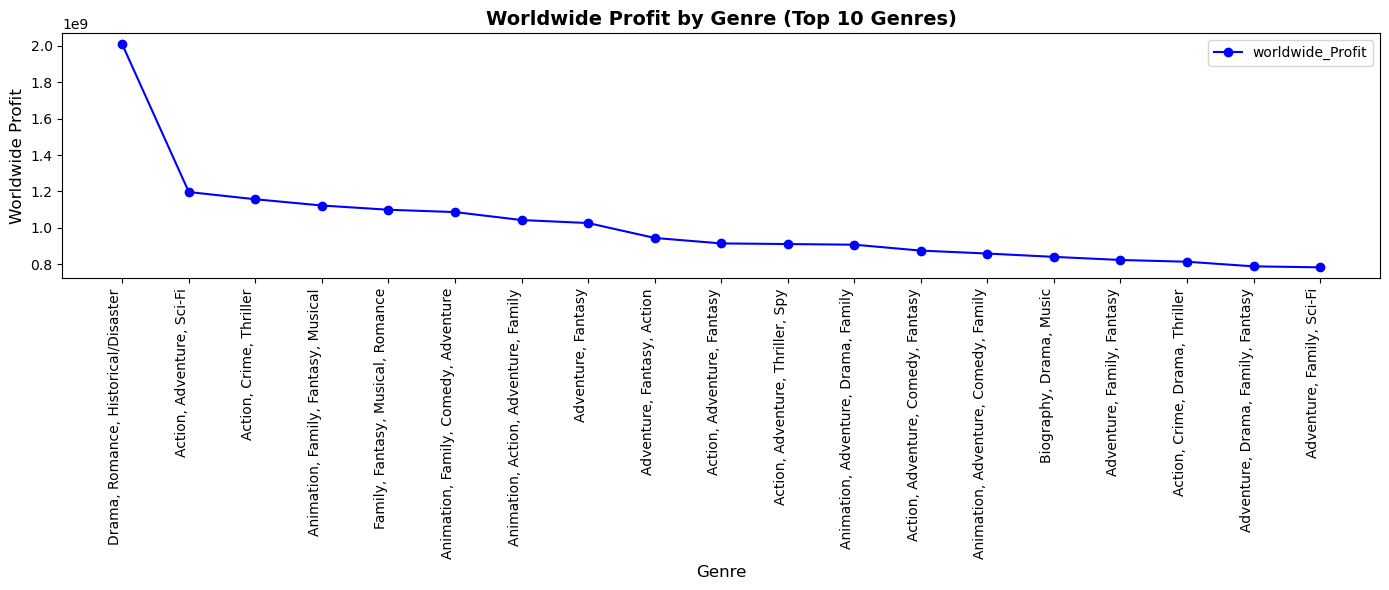

In [30]:
import os

# ✅ Make sure 'images' folder exists
os.makedirs("images", exist_ok=True)

# Sort and select top 10
top_10 = Agg_top_50_worldwide_profit.sort_values(by="worldwide_Profit", ascending=False)

# Line plot
ax = top_10.plot(
    x="Genre",
    y="worldwide_Profit",
    kind="line",
    marker="o",
    color="blue",
    figsize=(14,6)
)

plt.title("Worldwide Profit by Genre (Top 10 Genres)", fontsize=14, weight="bold")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Worldwide Profit", fontsize=12)

# Force all genre names to show
plt.xticks(ticks=range(len(top_10)), labels=top_10["Genre"], rotation=90, ha="right")

plt.tight_layout()

# ✅ Save the plot
plt.savefig("images/worldwide_profit.png", dpi=300, bbox_inches="tight")

plt.show()


# Modeling
## Selected Modeling Technique – Simple Linear Regression  

This analysis explores the relationship between **Porduction_budget** and **worldwide_Gross** using data extracted from `im.db`.  

### Approach  

To perform this analysis, we:  

- **Defined the variables**: identified *Production_budget* as the dependent variable (Y) and *worldwide_Gross* as the independent variable (X).
- **Formulate the hypotheses**:Put both H₀ and H₁
- **Visualized the relationship**: created a scatter plot to examine the potential correlation between the two variables.  
- **Built the model**: developed a simple linear regression model to quantify the relationship.  
- **Evaluated model performance**: assessed how well the model explains the variation in the data.  



In [31]:
# Import the relevant modules
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

ModuleNotFoundError: No module named 'statsmodels'

#### Step 1: 
**Defined the variables:** identified Production_budget as the dependent variable (Y) and worldwide_Gross as the independent variable (X).

#### Step 2:
**Formulate hypothesis:**
**H₀ (null):** There is no linear relationship between production budget and worldwide gross (correlation = 0).

**H₁ (alternative):** There is a linear relationship (correlation ≠ 0).

**Alpha** = 0.05
#### Step 3:

**Visualized the relationship:** Created a scatter plot to examine the potential correlation between the two variables.

<Axes: xlabel='production_budget', ylabel='worldwide_gross'>

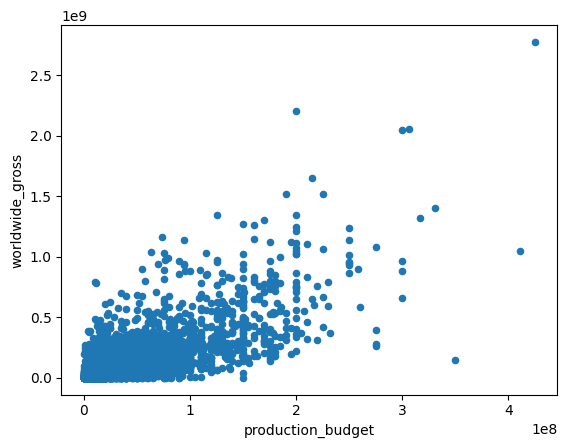

In [26]:
movie_budgets.plot.scatter(x = "production_budget", y= "worldwide_gross")

##### **Building a linear regression model** - to quantify the relationship between production budget and Worldwide Gross

In [27]:
# Create the first coefficient
rho = np.corrcoef(movie_budgets["production_budget"], movie_budgets["worldwide_gross"])[0][1]

In [28]:
# Standard deviation of x and y
s_y = movie_budgets["worldwide_gross"].std()
s_x = movie_budgets["production_budget"].std()

In [29]:
# The slope of the regression
m = rho * s_y /s_x

In [30]:
mean_y = movie_budgets["worldwide_gross"].mean()
mean_x = movie_budgets["production_budget"].mean()

In [31]:
#Intercept(constant) y = c+mx
c = mean_y - m * mean_x
c

np.float64(-7285667.054592013)

In [32]:
#print the regression line
print(f"Regression line: y = {round(m,4)}x + {round(c,4)}")

Regression line: y = 3.1269x + -7285667.0546


**Creating the model**

In [33]:
# Assign the x values and y values variables
x = movie_budgets["production_budget"]
y = movie_budgets["worldwide_gross"]

In [34]:
# ordinary list squire, endog(nous) = dependent variable
# exog(nous) = independent
model = sm.OLS(endog=y, exog=sm.add_constant(x))
model

In [35]:
# fit the model
result = model.fit()
result

**Evaluation**

F Test

In [36]:
result.fvalue

np.float64(7355.224292071473)

In [41]:
#get the pvalue for null hypothesis. Since
result.f_pvalue

np.float64(0.0)

**R Squared**

In [38]:
# 95 percent change in y is explained by y, the other 5 percent is error
result.rsquared

np.float64(0.5599618345695967)

In [39]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     7355.
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        22:57:20   Log-Likelihood:            -1.1557e+05
No. Observations:                5782   AIC:                         2.311e+05
Df Residuals:                    5780   BIC:                         2.311e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -7.286e+06   1.91e+0

**Visualizing the model**

<Axes: xlabel='production_budget', ylabel='worldwide_gross'>

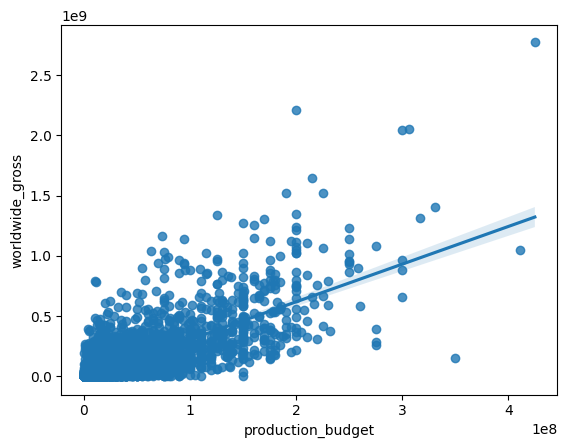

In [40]:
sns.regplot(x = "production_budget", y= "worldwide_gross", data = movie_budgets)

**Conclusion**:

F-statistics of 7355.2, meaning that the model is highly statistically significant.
P- value of 0.0 implies extreme significance. An Overwhelming evidence to reject the null hypotheses.

**Summary of Analysis Done:**
1. Top 3 worldwide highest profit-generating genres include:
- Drama, Romance, Historical/Disaster
- Action,Adventure, Sci-Fi
- Action,Crime, Thriller
  
2. Comedy ,Documentary ,Fantasy genre had the highest number of votes, however in terms of profits it is not among the top fifteen worldwide.

3. There is a  strong, statistically significant predictive relationship between production budget and worldwide gross. The   analysis proves correlation, not causation i.e.,

- Movies expected to be huge blockbusters (e.g., sure-fire sequels, superhero movies) are given large budgets because studios are confident they will make a lot of money.

- Both high budgets and high grosses are caused by a third factor, like the involvement of A-list directors or stars.
